# Libraries

In [4]:
import os
import sys
import pickle
import datetime, time
import random
from importlib import reload
from math import sqrt
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_paths = {os.pardir}  # package directory
sys.path.extend(module_paths.difference(sys.path))


from nytf import utils; reload(utils)
#from nytf import main_pipeline; reload(main_pipeline)
pass

# Loading dataframes

In [5]:
%%time
train = utils.load_dataframe('train')#, cloud=False)
train = pd.concat((train, utils.BasicTemporalFeatures().transform(train)), axis=1)

#with open(os.path.join(utils.PROCESSING_DIRECTORY, 'train_basic_features.pkl'), 'rb') as f:
#    train = pickle.load(f)

test = utils.load_dataframe('test')#, cloud=False)
test = pd.concat((test, utils.BasicTemporalFeatures().transform(test)), axis=1)

CPU times: user 5min 14s, sys: 1min 13s, total: 6min 27s
Wall time: 6min 37s


In [3]:
train.memory_usage().sum()/10**9  # In Go

5.402749

# RandomForest

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [80]:
%%time
N = 200000
ind = sorted(random.sample(range(train.shape[0]), N))
X = train.iloc[ind][['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].values
y = train.iloc[ind]['fare_amount'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

CPU times: user 6.94 s, sys: 391 ms, total: 7.33 s
Wall time: 7.32 s


In [51]:
regr = RandomForestRegressor()

In [52]:
%%time
regr.fit(X_train, y_train)

CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
%%time
y_train_est = regr.predict(X_train).clip(0, 100)
print('Train error :', sqrt(((y_train_est - y_train) ** 2).mean()))
y_test_est = regr.predict(X_test).clip(0, 100)
print('Test error :', sqrt(((y_test_est - y_test) ** 2).mean()))

Train error : 1.5772289366331023
Test error : 3.753414093080567
CPU times: user 3.7 s, sys: 0 ns, total: 3.7 s
Wall time: 3.7 s


# NeuralNetwork

In [6]:
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
%%time
X = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].values
y = train['fare_amount'].values

scaler = StandardScaler()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)
X = scaler.fit_transform(X)
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

CPU times: user 20.5 s, sys: 47.1 s, total: 1min 7s
Wall time: 1min 7s


In [8]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

In [9]:
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation=lambda tensor: tf.keras.activations.relu(tensor, max_value=100)))
model.compile(optimizer=tf.train.AdamOptimizer(0.01), loss='mse', metrics=[rmse])

In [10]:
model.fit(X, y, epochs=100, batch_size=2**20)

Epoch 1/100
54027490/54027490 [==============================] - 140s 3us/step - loss: 69.0168 - rmse: 7.8576
Epoch 2/100
54027490/54027490 [==============================] - 137s 3us/step - loss: 19.6326 - rmse: 4.4256
Epoch 3/100
54027490/54027490 [==============================] - 138s 3us/step - loss: 16.8208 - rmse: 4.1010
Epoch 4/100
54027490/54027490 [==============================] - 139s 3us/step - loss: 16.2506 - rmse: 4.0311
Epoch 5/100
54027490/54027490 [==============================] - 140s 3us/step - loss: 15.9815 - rmse: 3.9976
Epoch 6/100
54027490/54027490 [==============================] - 140s 3us/step - loss: 15.7828 - rmse: 3.9726
Epoch 7/100
54027490/54027490 [==============================] - 139s 3us/step - loss: 15.5852 - rmse: 3.9477
Epoch 8/100
54027490/54027490 [==============================] - 140s 3us/step - loss: 15.3982 - rmse: 3.9239
Epoch 9/100
54027490/54027490 [==============================] - 140s 3us/step - loss: 15.2565 - rmse: 3.9058
Epoch 10/1

In [11]:
model.save_weights('test.h5')

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  240       
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
_________________________________________________________________
dense_2 (Dense)              multiple                  528       
_________________________________________________________________
dense_3 (Dense)              multiple                  272       
_________________________________________________________________
dense_4 (Dense)              multiple                  17        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


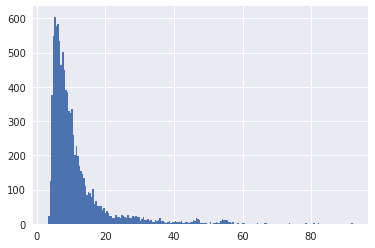

In [34]:
X_test = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].values

X_test = scaler.transform(X_test)
y_test_pred = model.predict(X_test)

plt.hist(y_test_pred, bins=200)
pass

In [35]:
test['fare_amount'] = y_test_pred

In [37]:
test.to_csv('first_neural_network.csv', index=False, columns=['key', 'fare_amount'])